## Normalizing Flows
Author: Marcin Mazur

### Setup

In [1]:
import os
import copy
import importlib.util
import operator
import functools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if importlib.util.find_spec('torchmetrics') is None:
    !pip install torchmetrics
if importlib.util.find_spec('torchinfo') is None:
    !pip install torchinfo

import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import src.helpers as H
from src.nn import RealNVP, NLLLoss
from torchinfo import summary


In [2]:
# Globals
SEED_VAL = 503
DATA_PATH = r'data/'
BATCH_SIZE = 128


In [3]:
seed = np.random.randint(SEED_VAL)
H.seed_all(seed)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using torch: {torch.__version__}')
print(f'Using torchvision: {torchvision.__version__}')
print(f'Using {DEVICE}')
if torch.cuda.is_available():
    !nvidia-smi


Using torch: 1.11.0
Using torchvision: 0.12.0
Using cuda
Sun Jun  5 20:34:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:26:00.0  On |                  N/A |
| 48%   44C    P5    N/A /  75W |    470MiB /  4038MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                               

### Data preparation

In [4]:
if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)
dataset = torchvision.datasets.MNIST(root=DATA_PATH,
                                     train=True,
                                     transform=T.ToTensor(),
                                     download=(not os.path.isdir(DATA_PATH + 'MNIST')))
x = (dataset.data.float() / 255. - 0.5)
y = dataset.targets
x = x[y == 5]

dataloader = torch.utils.data.DataLoader(x, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


### Model

In [5]:
img_shape = (1, 28, 28)
dims = [
    [1024, 2048, 1024],
    [1024, 2048, 1024],
    [1024, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 4096, 1024, 2048, 4096, 1024],
    [1024, 2048, 4096, 2048, 4096, 1024, 2048, 4096, 1024],
    [1024, 2048, 4096, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 1024],
    [1024, 2048, 4096, 2048, 1024],
]
model = RealNVP(dims, img_shape, DEVICE)
nll = NLLLoss(DEVICE)

summary(model, (4, *img_shape))


Layer (type:depth-idx)                   Output Shape              Param #
RealNVP                                  --                        --
├─CouplingLayer: 1-1                     [4, 784]                  --
│    └─MLP: 2-1                          [4, 392]                  --
│    │    └─Sequential: 3-1              [4, 512]                  202,240
│    │    └─Sequential: 3-2              [4, 1024]                 527,360
│    │    └─Sequential: 3-3              [4, 512]                  525,824
│    │    └─Linear: 3-4                  [4, 392]                  201,096
│    └─MLP: 2-2                          [4, 392]                  --
│    │    └─Sequential: 3-5              [4, 512]                  202,240
│    │    └─Sequential: 3-6              [4, 1024]                 527,360
│    │    └─Sequential: 3-7              [4, 512]                  525,824
│    │    └─Linear: 3-8                  [4, 392]                  201,096
├─CouplingLayer: 1-2                     [4, 

### Training

In [6]:
n_epochs = 100
lr = 1e-3
eps = 1e-8

optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=eps)
sched_cut = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=6, min_lr=1e-6, verbose=True)
sched_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, end_factor=1.0, total_iters=10)

noise_batch = 8
raport_gap = 10


Epoch: [   10 /  100] Loss: -960.48


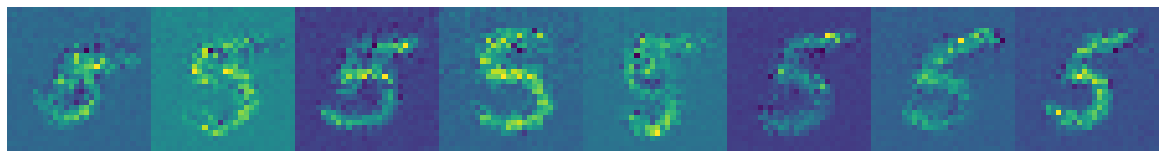

Epoch: [   20 /  100] Loss: -1154.50


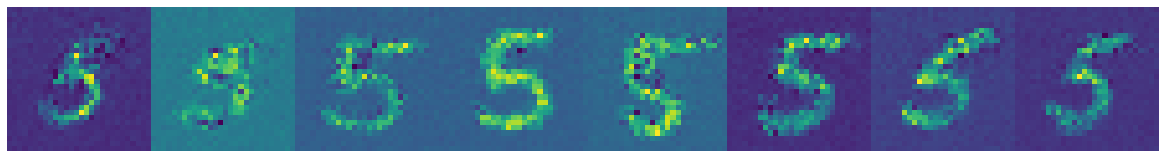

Epoch: [   30 /  100] Loss: -1322.76


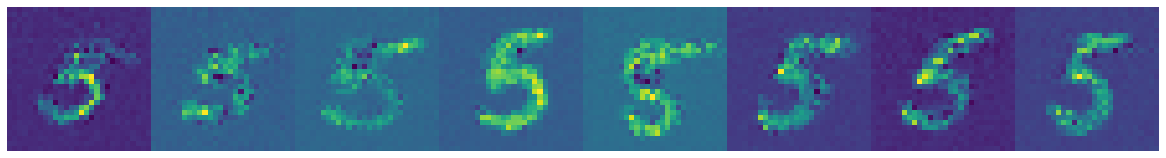

Epoch: [   40 /  100] Loss: -1336.47


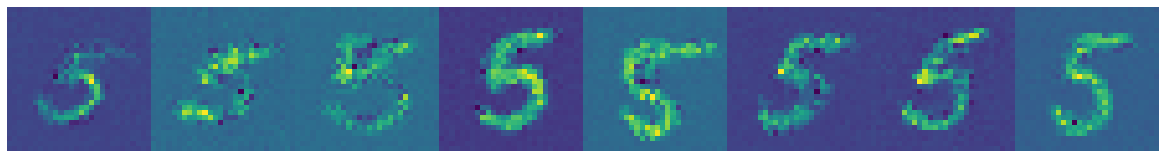

Epoch 00042: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [   50 /  100] Loss: -1473.27


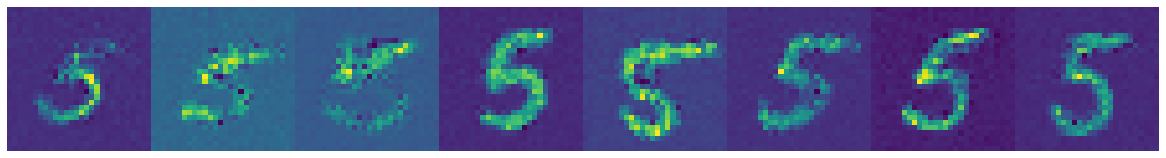

Epoch: [   60 /  100] Loss: -1509.28


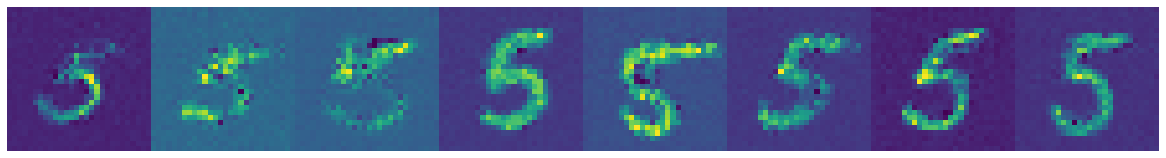

Epoch: [   70 /  100] Loss: -1528.52


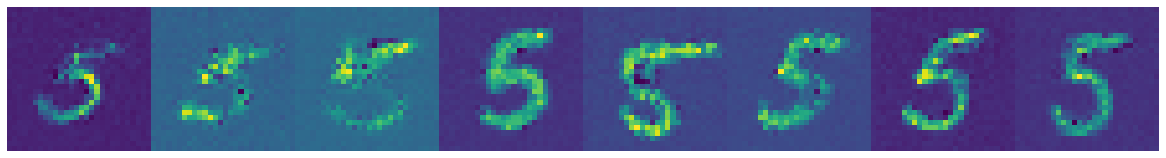

Epoch: [   80 /  100] Loss: -1546.43


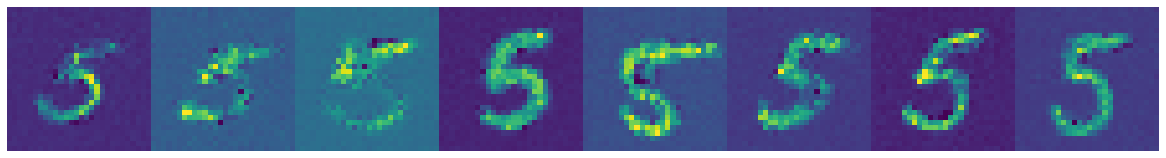

Epoch: [   90 /  100] Loss: -1544.12


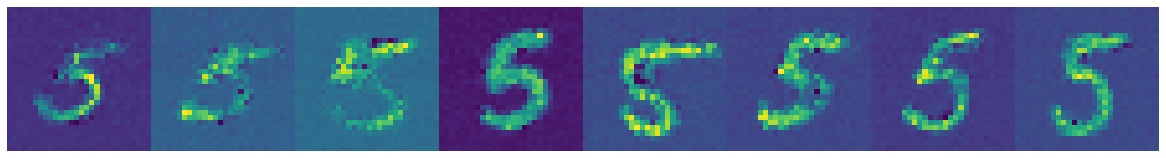

Epoch: [  100 /  100] Loss: -1568.84


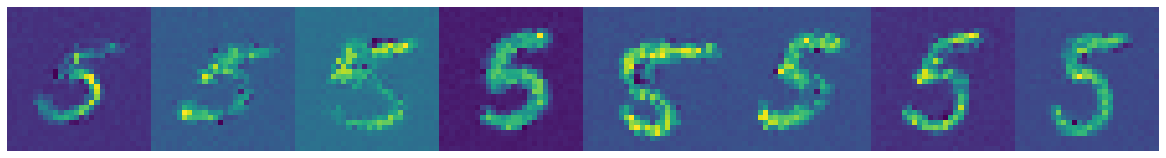

'04_Jun_2022_18-loss_1568'

In [7]:
sample_noise = nll.normal.sample((noise_batch, functools.reduce(operator.mul, img_shape))).squeeze().to(DEVICE)
best_loss = np.inf
best_model = None
losses = []

for i in range(n_epochs):
    model.train()
    loss_acc = 0

    # Training
    for j, x in enumerate(dataloader):
        optimizer.zero_grad()
        x.unsqueeze_(dim=1)
        x = (x.float() + torch.randn(x.shape) / 64).to(DEVICE)
        z, log_det_jacobian = model(x)
        loss = nll(z, log_det_jacobian)
        loss_acc += loss.item()
        loss.backward()
        optimizer.step()

    # Raport
    if (i + 1) % raport_gap == 0:
        print(f'Epoch: [{i + 1:5d} / {n_epochs:4d}] Loss: {(loss_acc / (j + 1)):.2f}')
        with torch.no_grad():
            model.eval()
            samples = model.inverse_flow(sample_noise)
            H.plot(samples.squeeze())

        # Save best model
        if loss_acc < best_loss:
            best_loss = loss_acc / (j + 1)
            model.cpu() # Due to gpu memory constraint
            best_model = copy.deepcopy(model.state_dict())
            model.to(DEVICE)

    # Scheduling
    sched_cut.step(loss_acc)
    sched_warmup.step()
    
    losses.append(loss_acc / (j + 1))

H.save_model(best_model, best_loss)


### Report

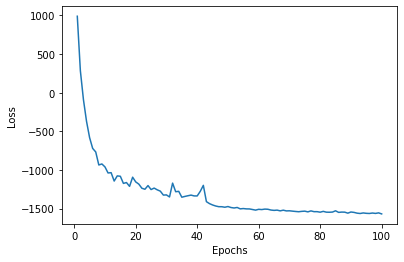

In [8]:
H.plot_loss(losses, title='Loss')


### Linear Interpolation

In [13]:
# model.load_state_dict(torch.load('models/04_Jun_2022_18-loss_1568.ckpt'))
model.load_state_dict(best_model)
model.eval()


RealNVP(
  (CL0): CouplingLayer(
    (s_mlp): MLP(
      (L0): Sequential(
        (0): Linear(in_features=392, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (L1): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (L2): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.06, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (L3): Linear(in_features=512, out_features=392, bias=True)
    )
    (t_mlp): MLP(
      (L0): Sequential(
        (0): Linear(in_features=392, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.06, aff

Samples from normal distribution:


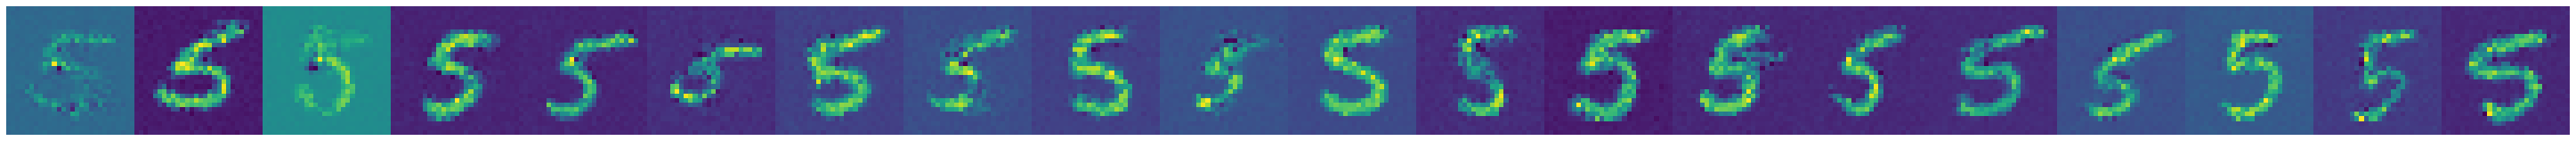

Samples from linear interpolation:


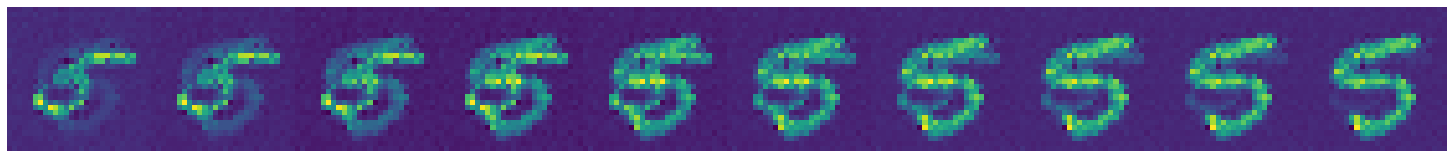

In [19]:
with torch.no_grad():
    sample_noise = nll.normal.sample((20, functools.reduce(operator.mul, img_shape))).squeeze().to(DEVICE)
    samples = model.inverse_flow(sample_noise)
    print('Samples from normal distribution:')
    H.plot(samples.squeeze(), title='Samples')
    smp1, smp2 = H.find_contrasting(samples)
    interpolated_samples = H.lin_inter(smp1, smp2)
    print('Samples from linear interpolation:')
    H.plot(interpolated_samples)


### Inprinting

Samples for inprinting:


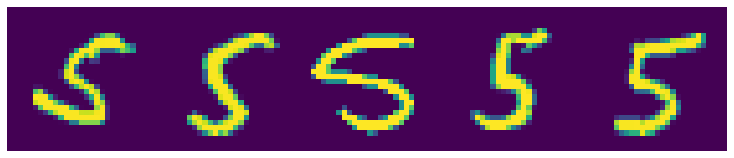

Occluded samples for inprinting:


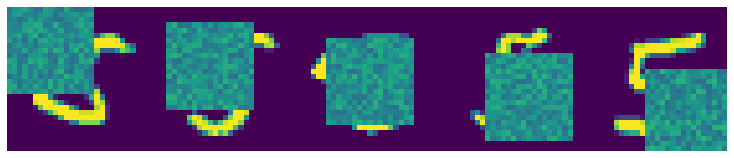

In [16]:
samples = next(iter(dataloader))[:5].unsqueeze(dim=1).to(DEVICE)
print('Samples for inprinting:')
H.plot(samples.squeeze())
occluded_samples, masks = H.occlude(samples)
print('Occluded samples for inprinting:')
H.plot(occluded_samples.squeeze())


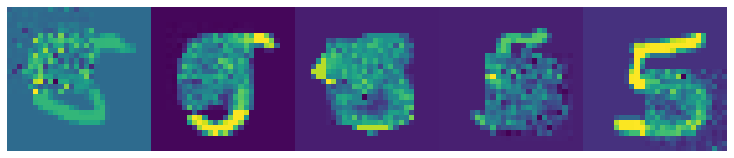

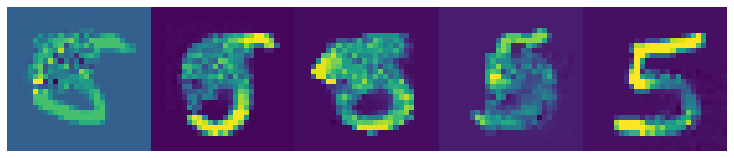

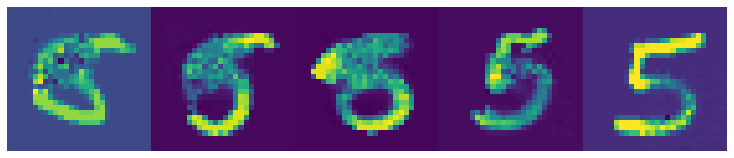

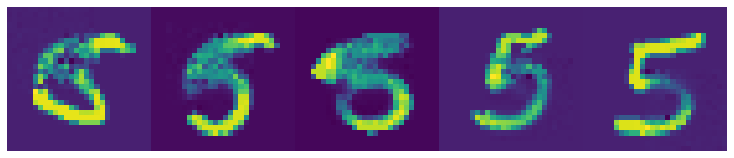

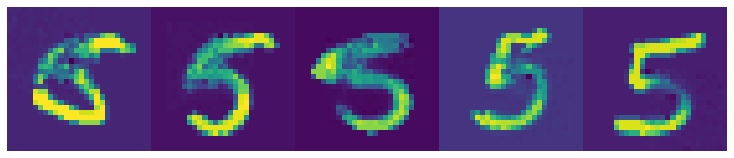

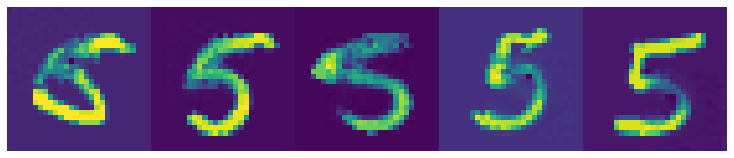

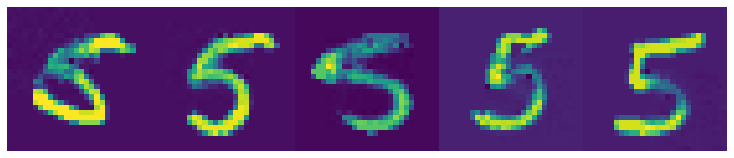

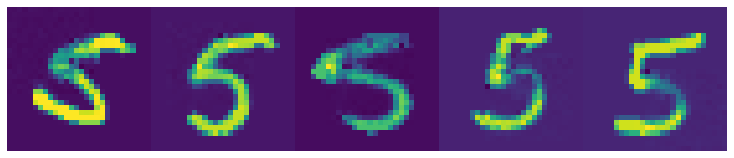

In [17]:
flat_in = functools.reduce(operator.mul, img_shape)
occluded_part = occluded_samples[~masks]
occluded_part.requires_grad_()
optimizer = torch.optim.SGD([occluded_part], lr=1e-3)
epochs = 1600
report_gap = 200

for i in range(epochs):
    optimizer.zero_grad()
    occluded_samples_ = torch.clone(occluded_samples)
    occluded_samples_[~masks] = occluded_part
    z, log_det_jacobian = model(occluded_samples_)
    loss = nll(z, log_det_jacobian)
    loss.backward()
    optimizer.step()
    del(occluded_samples_)
    
    if (i + 1) % report_gap == 0:
        with torch.no_grad():
            occluded_samples_ = torch.clone(occluded_samples)
            occluded_samples_[~masks] = occluded_part
            z, _ = model(occluded_samples_)
            img_from_distr = model.inverse_flow(z)
            H.plot(img_from_distr.squeeze())
            del(occluded_samples_)
